In [1]:
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# make variables display whenever they are on their own line (not just the last line of a cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import os

import tensorflow as tf
from tensorflow.contrib.slim import nets
import numpy as np
import matplotlib.pyplot as plt

from utils import *

C:\Anaconda\envs\style\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
tf.reset_default_graph()
sess = tf.Session()

input_ph = tf.placeholder('float', (None, 224, 224, 3))
vgg = nets.vgg.vgg_19(input_ph)

In [6]:
saver = tf.train.Saver()
saver.restore(sess, 'vgg_19.ckpt')

INFO:tensorflow:Restoring parameters from vgg_19.ckpt


In [7]:
filenames = [os.path.join('../data', d) for d in os.listdir('../data')]
filenames = tf.constant(filenames)
def _parse_function(filename):
    image = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image, channels=3)
    image_resized = tf.image.resize_images(image_decoded, [224, 224],
                                          method=tf.image.ResizeMethod.BILINEAR)
    return image_resized

dataset = tf.data.Dataset.from_tensor_slices(filenames)
dataset = dataset.map(_parse_function)

In [8]:
reconstructed_image = make_decoder(vgg[1]['vgg_19/conv2/conv2_1'], [(3, 64), 'upsample', (3, 64), (3, 3)], sess)

In [9]:
loss = tf.sqrt(tf.reduce_mean(tf.square(input_ph - reconstructed_image)))

In [29]:
train(loss, dataset, input_ph, sess, num_epochs=10, lr=1e-4)

[<tf.Variable 'decoder/conv_layer_0/filters:0' shape=(3, 3, 128, 64) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_0/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_2/filters:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_2/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_3/filters:0' shape=(3, 3, 64, 3) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_3/biases:0' shape=(3,) dtype=float32_ref>]
[b'beta1_power_4' b'beta2_power_4' b'decoder/conv_layer_0/filters/Adam_8'
 b'decoder/conv_layer_0/filters/Adam_9'
 b'decoder/conv_layer_0/biases/Adam_8'
 b'decoder/conv_layer_0/biases/Adam_9'
 b'decoder/conv_layer_2/filters/Adam_8'
 b'decoder/conv_layer_2/filters/Adam_9'
 b'decoder/conv_layer_2/biases/Adam_8'
 b'decoder/conv_layer_2/biases/Adam_9'
 b'decoder/conv_layer_3/filters/Adam_8'
 b'decoder/conv_layer_3/filters/Adam_9'
 b'decoder/conv_layer_3/biases/Adam_8'
 b'decoder/conv_layer_3/biases/Adam_9']

In [11]:
it = dataset.make_one_shot_iterator()

In [54]:
img = sess.run(tf.cast(it.get_next(), tf.uint8))

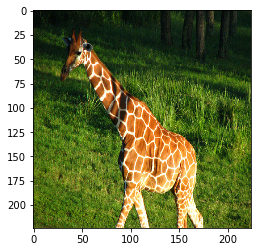

In [55]:
plt.imshow(img)

In [56]:
decoded_img = sess.run(reconstructed_image, feed_dict={input_ph: img[np.newaxis,:,:,:]})

In [57]:
decoded_img = np.squeeze(decoded_img)

In [58]:
decoded_img[decoded_img > 255] = 255

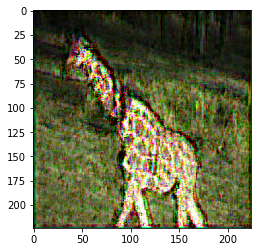

In [59]:
plt.imshow(decoded_img.astype(np.uint8))